#IMPORTING LIBRARIES

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, classification_report
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters.rank import median
import math
import scipy.signal
from skimage.filters import rank
import skimage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
args = {'training_dataset': '/content/gdrive/My Drive/knn_data/training', 'testing_dataset': '/content/gdrive/My Drive/knn_data/testing'}

imagePaths = list(paths.list_images(args["testing_dataset"]))
imagePaths_test = list(paths.list_images(args["training_dataset"]))

# PREPROCESSING 1

In [ ]:
# CV2 provides various options for thresholding. adaptive threshold gave better results than simple threshold
def threshold(imgOverlap,th, kkk):
  #thresh, blackAndWhiteImage = cv2.threshold(imgOverlap, th, 255, cv2.THRESH_OTSU)
  blackAndWhiteImage=cv2.adaptiveThreshold(imgOverlap,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                           cv2.THRESH_BINARY,33,2)
  if kkk == True:
    for jj in range (blackAndWhiteImage.shape[0]):
      for kk in range (blackAndWhiteImage.shape[1]):
        if blackAndWhiteImage[jj][kk] == np.uint8(255):
          blackAndWhiteImage[jj][kk] = np.uint8(0)
        else:
          blackAndWhiteImage[jj][kk] = np.uint8(255)
  imgBw = blackAndWhiteImage
  return imgBw

# reducing noise by blurring and removing high frequency components
def median_filter(grayImg):
  medImg = cv2.medianBlur(grayImg,5)
  #medImg =scipy.signal.medfilt2d(grayImg,3)
  #medImg = (medImg + scipy.signal.medfilt2d(grayImg,3)).astype(np.uint8)
  return medImg

def Pt(x0, y0, x1, y1):
   points = []
   dx, dy = abs(x1 - x0), abs(y1 - y0)
   x, y = x0, y0
   sx = -1 if x0 > x1 else 1
   sy = -1 if y0 > y1 else 1
   if dx > dy:
      err = dx /2
      while x != x1:
         points.append((x, y))
         err -= dy
         if err < 0:
            y += sy
            err += dx
         x += sx
   else:
      err = dy / 2.0
      while y != y1:
         points.append((x, y))
         err -= dx
         if err < 0:
            x += sx
            err += dy
         y += sy
   points.append((x, y))
   return points

# creating structural elements in 6 directions which can open features in 6 different directions
def strel_line(length, degrees):
   if length >= 1:
      theta = degrees*np.pi/180
      x = round((length - 1) / 2 * np.cos(theta))
      y = -round((length - 1) / 2 * np.sin(theta))
      points = Pt(-x, -y, x, y)
      points_x = [point[0] for point in points]
      points_y = [point[1] for point in points]
      n_rows = int(2 * max([abs(point_y) for point_y in points_y]) + 1)
      n_columns = int(2 * max([abs(point_x) for point_x in points_x]) + 1)
      strel = np.zeros((n_rows, n_columns))
      rows = ([point_y + max([abs(point_y) for point_y in points_y]) for point_y in points_y])
      columns = ([point_x + max([abs(point_x) for point_x in points_x]) for point_x in points_x])
      idx = []
      for x in zip(rows, columns):
         idx.append(np.ravel_multi_index((int(x[0]), int(x[1])), (n_rows, n_columns)))
      strel.reshape(-1)[idx] = 1
      strel = strel.astype(np.uint8)
   return strel

def opening_img(medImg):
  SE = []
  for ii in range (6):
    SE.append(strel_line(15,ii*30))
  #medImg = cv2.cvtColor(medImg,cv2.COLOR_BGR2GRAY)
  imgOpen=np.zeros([6,np.shape(medImg)[0],np.shape(medImg)[1]])
  # Image opening in the six direction for each gray level image and Overlap Image to Single one
  for j in range (6):
    imgOpen[j]=cv2.morphologyEx(medImg, cv2.MORPH_OPEN, SE[j])
    if j==5:
      imgOverlap=imgOpen[0]
      for l in range (1,5):
        imgOverlap = cv2.addWeighted(imgOverlap,0.6,imgOpen[l],0.4,0.0) 
        # np.dstackdst = cv.addWeighted(src1, alpha, src2, beta, 0.0)
  return imgOverlap

def pre_processing(grayImg):
  medImg = median_filter(grayImg)
  imgOverlap = opening_img(medImg)
  imgOverlap1 = np.uint8(imgOverlap)
  imgBw = threshold(imgOverlap1,127, kkk=False)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  imgBw21 = cv2.erode(imgBw, kernel, iterations = 1)
  return imgBw21, medImg, imgOverlap

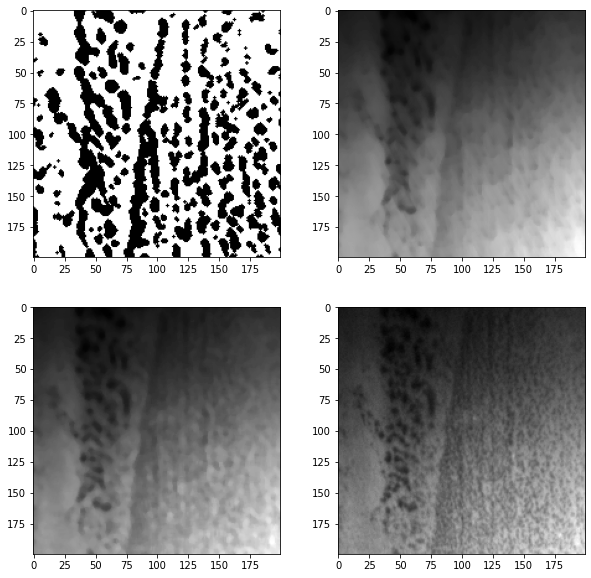

In [ ]:
image = cv2.imread('/content/gdrive/My Drive/knn_data/testing/pitted_surface/PS_2.bmp',0)
imgBw, medImg, imgOverlap = pre_processing(image)
fig,plot= plt.subplots(2,2,figsize=(10,10))
#plt.subplots_adjust(hspace=0.1, wspace=0.1)
plot[0,0].imshow(imgBw,cmap='gray')
plot[0,1].imshow(imgOverlap,cmap='gray')
plot[1,0].imshow(medImg,cmap='gray')
plot[1,1].imshow(image,cmap='gray')

#PREPROCESSING 2

In [ ]:
def threshold(imgOverlap,th, kkk):
  #(thresh, blackAndWhiteImage) = cv2.threshold(imgOverlap, th, 255, cv2.THRESH_OTSU)
  blackAndWhiteImage=cv2.adaptiveThreshold(imgOverlap,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                                           cv2.THRESH_BINARY,19,1.9)
  if kkk == True:
    for jj in range (blackAndWhiteImage.shape[0]):
      for kk in range (blackAndWhiteImage.shape[1]):
        if blackAndWhiteImage[jj][kk] == np.uint8(255):
          blackAndWhiteImage[jj][kk] = np.uint8(0)
        else:
          blackAndWhiteImage[jj][kk] = np.uint8(255)
  imgBw = blackAndWhiteImage
  return imgBw

def gaussblur(sigma, grayImg):
  grayImg = cv2.resize(grayImg, (0, 0), fx=2, fy=2)
  sigma1 = np.sqrt(max((sigma ** 2) - 1, 0.01))
  k = cv2.GaussianBlur(grayImg, (0, 0), sigmaX=sigma1, sigmaY=sigma1)
  return k

# laplacian of gaussian is used to retain the best features 
def laplacian(imgg):
  ddepth = cv2.CV_16S
  dst = cv2.Laplacian(imgg, ddepth, ksize=3)
  abs_dst = cv2.convertScaleAbs(dst)
  jk = abs_dst
  return jk

def pre_processing2(grayImg):
  medImg2 = gaussblur(0.93, grayImg)
  imgOverlap2 = laplacian(medImg2) #medImg2
  imgBw21 = threshold(imgOverlap2,127, kkk=True)
  kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))# kernel2 = np.ones((3,3),np.uint8)
  d = cv2.erode(imgBw21, kernel2, iterations = 2)
  #kernel = np.ones((2,2),np.uint8)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
  imgBw2 = cv2.dilate(d, kernel, iterations = 3)
  return imgBw2, d, imgBw21, imgOverlap2, medImg2

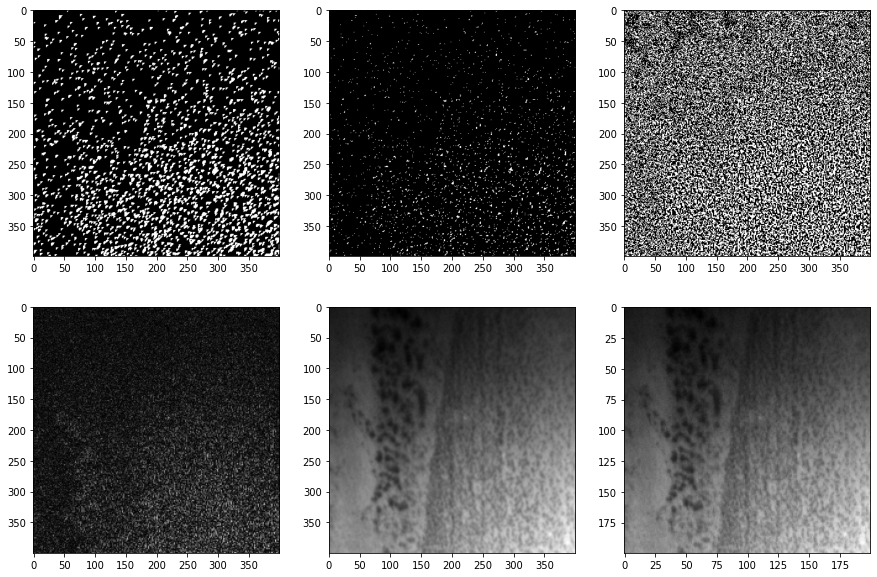

In [ ]:
image = cv2.imread('/content/gdrive/My Drive/knn_data/testing/pitted_surface/PS_2.bmp', 0)
imgBw2, d, imgBw21, imgOverlap2, medImg2 = pre_processing2(image)
fig,plot= plt.subplots(2,3,figsize=(15,10))
#plt.subplots_adjust(hspace=0.1, wspace=0.1)
plot[0,0].imshow(imgBw2,cmap='gray')
plot[0,1].imshow(d,cmap='gray')
plot[0,2].imshow(imgBw21,cmap='gray')
plot[1,0].imshow(imgOverlap2,cmap='gray')
plot[1,1].imshow(medImg2,cmap='gray')
plot[1,2].imshow(image,cmap='gray')

#PREPROCESSING 3

In [ ]:
def pre_processing3(img,d1,d2):
  # histogram equalization & intensity rescaling to counter uneven brightness
  img_rescale = skimage.exposure.equalize_hist(img)#clip_limit=0.1)
  img_eq = rank.equalize(img_rescale, selem=disk(d1))
  #p2, p98 = np.percentile(img_rescale, (15, 85))
  #img_eq = skimage.exposure.rescale_intensity(img_rescale, in_range=(p2, p98))
  noisy_image = img_eq
  noise = np.random.random(noisy_image.shape)
  noisy_image[noise > 0.99] = 255
  noisy_image[noise < 0.01] = 0
  img111 = median(np.uint8(noisy_image), disk(d2))
  #thresh, img112 = cv2.threshold(img111, 98, 255, cv2.THRESH_OTSU)
  return img111, img_eq, img_rescale

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


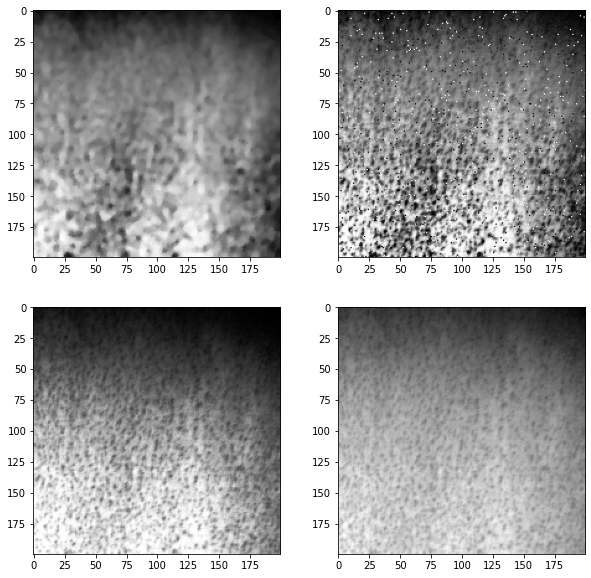

In [ ]:
image = cv2.imread('/content/gdrive/My Drive/knn_data/testing/pitted_surface/PS_11.bmp',0)
img111, img_eq, img_rescale = pre_processing3(image,76,3)
fig,plot= plt.subplots(2,2,figsize=(10,10))
#plt.subplots_adjust(hspace=0.1, wspace=0.1)
plot[0,0].imshow(img111,cmap='gray')
plot[0,1].imshow(img_eq,cmap='gray')
plot[1,0].imshow(img_rescale,cmap='gray')
plot[1,1].imshow(image,cmap='gray')

#FEATURE EXTRACTION

In [ ]:
# Converting image into a 1D array by flattening it
def image_to_feature_vector(image, size=(32, 32)):
    return cv2.resize(image, size).flatten()

# extracting histogram of the image to use as feature vector
def extract_color_histogram(image, bins=(8, 8, 8)):
  hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
  hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
  cv2.normalize(hist, hist)
  return hist.flatten()

def extract_BW_histogram(image):
  hist_full = cv2.calcHist([image],[0],None,[256],[0,256])
  cv2.normalize(hist_full, hist_full)
  return hist_full.flatten()

def prepare_data(imagePaths):
    rawImages, features, labels, preprocIm, preprocF, preprocIm1, preprocF1, preprocIm2, preprocF2 = [],[],[],[],[],[],[],[],[]
    # extracting labels of training data 
    for (i, imagePath) in enumerate(imagePaths):    
        image = cv2.imread(imagePath)
        label = imagePath.split(os.path.sep)[-1].split(".")[0].split("_")[0]
        if label== 'Cr':
          lb =1
        elif label == 'In':
          lb =2
        elif label == 'Pa':
          lb=3
        elif label == 'PS':
          lb=4
        elif label =='RS':
          lb=5
        elif label =='Sc':
          lb=6

        # creating 6 types of models for 3 pre processing experiments eachwith flattened image and histogram values as feature vectors
        labels.append(lb)
        rawImages.append(image_to_feature_vector(image))
        features.append(extract_color_histogram(image))
        image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        imgBw, medImg, imgOverlap = pre_processing(image1)
        preprocIm.append(image_to_feature_vector(imgBw))
        preprocF.append(extract_BW_histogram(imgBw))

        imgBw2, d, imgBw21, imgOverlap2, medImg2= pre_processing2(image1)
        preprocIm1.append(image_to_feature_vector(imgBw2))
        preprocF1.append(extract_BW_histogram(imgBw2))

        img111, img_eq, img_rescale = pre_processing3(image1,78,3)
        preprocIm2.append(image_to_feature_vector(img111))
        preprocF2.append(extract_BW_histogram(img111))

    return labels, rawImages, features, preprocIm, preprocF, preprocIm1, preprocF1, preprocIm2, preprocF2 

In [ ]:
labels, rawImages, features, preprocIm, preprocF, preprocIm1, preprocF1, preprocIm2, preprocF2  = prepare_data(imagePaths)

Lab = np.array(labels)
RawIm = np.array(rawImages)
RawFe = np.array(features)
PPIm = np.array(preprocIm)
PPFe= np.array(preprocF)
PPIm1 = np.array(preprocIm1)
PPFe1= np.array(preprocF1)
PPIm2 = np.array(preprocIm2)
PPFe2= np.array(preprocF2)

#MACHINE LEARNING MODELS

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBclf = GradientBoostingClassifier().fit(train_i, trainL1)
acc_GB = GBclf.score(test_i, testL1)

print("raw pixel accuracy for LR classifier: {:.2f}%".format(acc_GB * 100))

GBclf = GradientBoostingClassifier().fit(train_f, trainL)
acc_GB = GBclf.score(test_f, testL)

print("histogram accuracy for LR classifier: {:.2f}%".format(acc_GB * 100))

In [ ]:
# creating same type of data for all the models so that correct comparision is made
train_test_data=[]
train_test_data.append(train_test_split(RawFe, Lab, test_size=0.25, random_state=40))
train_test_data.append(train_test_split(RawIm, Lab, test_size=0.25, random_state=40))
train_test_data_pp =[]
train_test_data_pp.append(train_test_split(PPFe, Lab, test_size=0.25, random_state=40))
train_test_data_pp.append(train_test_split(PPIm, Lab, test_size=0.25, random_state=40))
train_test_data_pp1 =[]
train_test_data_pp1.append(train_test_split(PPFe1, Lab, test_size=0.25, random_state=40))
train_test_data_pp1.append(train_test_split(PPIm1, Lab, test_size=0.25, random_state=40))
train_test_data_pp2 =[]
train_test_data_pp2.append(train_test_split(PPFe2, Lab, test_size=0.25, random_state=40))
train_test_data_pp2.append(train_test_split(PPIm2, Lab, test_size=0.25, random_state=40))

In [ ]:
# Function to return accuracy
def MLmodel_accuracy(model, train_test_data):
  acc=[]
  train_i, test_i, trainL1, testL1 = train_test_data[0]
  train_f, test_f, trainL2, testL2 = train_test_data[1]
  model.fit(train_i,trainL1)
  acc.append(model.score(test_i, testL1))
  model.fit(train_f,trainL2)
  acc.append(model.score(test_f, testL2))  
  return acc

# scaling of data between 0,1 by using min max scaler for better results
def scaled_data(train_test_data):
  train_i, test_i, trainL1, testL1 = train_test_data[0]
  train_f, test_f, trainL2, testL2 = train_test_data[1]
  scaler = MinMaxScaler()
  train_sci = scaler.fit_transform(train_i)
  test_sci= scaler.transform(test_i)
  train_scf = scaler.fit_transform(train_f)
  test_scf= scaler.transform(test_f)
  train_test_data[0]=train_sci, test_sci, trainL1, testL1
  train_test_data[1]=train_scf, test_scf, trainL1, testL1
  return train_test_data

def Comp_ML_Models(train_test_data):
  Accuracy=[]
  model = KNeighborsClassifier(n_neighbors=1, n_jobs=1)
  Accuracy.append(MLmodel_accuracy(model, train_test_data))
  
  model1 = LinearSVC(C=3.2)
  Accuracy.append(MLmodel_accuracy(model1, scaled_data(train_test_data)))

  model2 = SVC(C=4,kernel='rbf')
  Accuracy.append(MLmodel_accuracy(model2, scaled_data(train_test_data)))

  model3 = LogisticRegression(solver = 'lbfgs')
  Accuracy.append(MLmodel_accuracy(model3, scaled_data(train_test_data)))

  model4 = DecisionTreeClassifier()
  Accuracy.append(MLmodel_accuracy(model4, train_test_data))

  model5 = GaussianNB()
  Accuracy.append(MLmodel_accuracy(model5, train_test_data))

  model6 = RandomForestClassifier()
  Accuracy.append(MLmodel_accuracy(model6, train_test_data))

  model7 = MLPClassifier(hidden_layer_sizes = [62,62], solver='lbfgs',activation='tanh', random_state = 0)
  Accuracy.append(MLmodel_accuracy(model7, scaled_data(train_test_data)))
  
  return Accuracy

def Grouped_bargraph(train_test_data):
  AE=np.array(Comp_ML_Models(train_test_data))
  labels11 = ['KNN','Linear SVC', 'Kernel SVC', 'LR','D Tree','Gaussian NB','R Forest', 'NN']
  Images11 = AE[:,0]
  Hist_Feat = AE[:,1]

  x = np.arange(len(labels11))
  width = 0.48
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, Images11, width, label='Images')
  rects2 = ax.bar(x + width/2, Hist_Feat, width, label='Histogram vector')

  def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",ha='center', va='bottom')
        
  autolabel(rects1)
  autolabel(rects2)
  ax.set_ylabel('Accuracy')
  ax.set_title('Conventional ML models')
  ax.set_xticks(x)
  ax.set_xticklabels(labels11,rotation=45)
  ax.legend()
  fig.tight_layout()
  plt.show()
  return

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


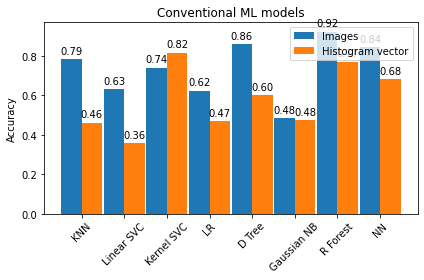

In [ ]:
Grouped_bargraph(train_test_data)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:


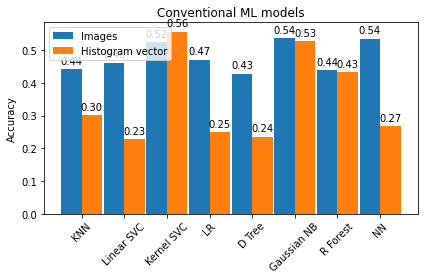

In [ ]:
Grouped_bargraph(train_test_data_pp)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


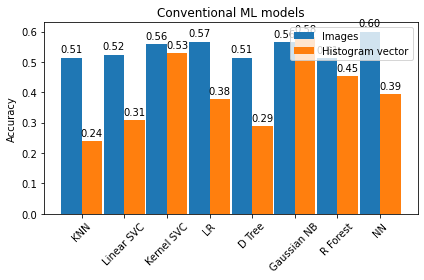

In [ ]:
Grouped_bargraph(train_test_data_pp1)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.p

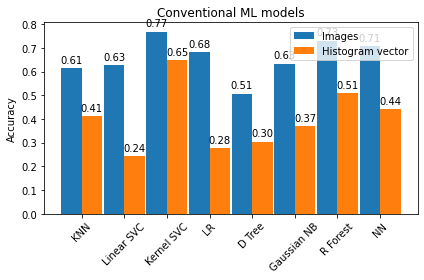

In [ ]:
Grouped_bargraph(train_test_data_pp2)

#EVALUATION METRICS

In [ ]:
def PrecisionRecallCurve(X_test, y_test, X_train, y_train,clf):
  #y_scores_clf = clf.predict(X_test)
  y_scores_clf = clf.fit(X_train, y_train).decision_function(X_test)
  precision, recall, thresholds = precision_recall_curve(y_test, y_scores_clf)
  closest_zero = np.argmin(np.abs(thresholds))
  closest_zero_p = precision[closest_zero]
  closest_zero_r = recall[closest_zero]
  plt.figure()
  plt.plot(precision, recall)
  plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 8)
  plt.xlabel('Precision')
  plt.ylabel('Recall')
  plt.title('Precision-Recall Curve')
  plt.show()
  return
def ROCCurve(X_test, y_test, X_train, y_train,clf):
  #y_scores_clf = clf.predict(X_test)
  y_scores_clf = clf.fit(X_train, y_train).decision_function(X_test)
  fpr_clf, tpr_clf, _ = roc_curve(y_test, y_scores_clf)
  roc_auc_clf = auc(fpr_clf, tpr_clf)
  plt.figure()
  plt.plot(fpr_clf, tpr_clf, lw=3)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.show()
  return

FOR BEST MODEL WITH NO PRE PROC

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
model6 = RandomForestClassifier()
train_i, test_i, trainL1, testL1 = train_test_data[0]
model6.fit(train_i,trainL1)
rfc_predicted2 = model6.predict(test_i)
confusion2 = confusion_matrix(testL1, rfc_predicted2)

print('\n Confusion matrix for Random forrest classifier\n', confusion2)
print('\n',classification_report(testL1, rfc_predicted2))
print('Micro average is :\n',precision_score(testL1, rfc_predicted2,average='micro'))


 Confusion matrix for Random forrest classifier
 [[74  0  2  1  1  1]
 [ 0 52  0  4  1  1]
 [ 2  0 68  0  0  0]
 [ 3  3  1 77  1  0]
 [ 0  8  0  1 56  1]
 [ 0  2  0  0  2 58]]

               precision    recall  f1-score   support

           1       0.94      0.94      0.94        79
           2       0.80      0.90      0.85        58
           3       0.96      0.97      0.96        70
           4       0.93      0.91      0.92        85
           5       0.92      0.85      0.88        66
           6       0.95      0.94      0.94        62

    accuracy                           0.92       420
   macro avg       0.92      0.92      0.91       420
weighted avg       0.92      0.92      0.92       420

Micro average is :
 0.9166666666666666


FOR BEST MODEL WITH PRE PROC 1

In [ ]:
model2 = SVC(C=4,kernel='rbf')
train_i, test_i, trainL1, testL1 = train_test_data_pp[1]
model2.fit(train_i,trainL1)
svm_predicted2 = model2.predict(test_i)
confusion2 = confusion_matrix(testL1, svm_predicted2)
print('\n Confusion matrix for Random forrest classifier\n', confusion2)
print('\n',classification_report(testL1, svm_predicted2))
print('Micro average is :\n',precision_score(testL1, svm_predicted2,average='micro'))


 Confusion matrix for Random forrest classifier
 [[55  0 18  2  4  0]
 [ 0 41  0  3  0 14]
 [24  0 39  4  3  0]
 [12  5  5 30 21 12]
 [ 2  0  1 16 46  1]
 [ 1 22  2  8  6 23]]

               precision    recall  f1-score   support

           1       0.59      0.70      0.64        79
           2       0.60      0.71      0.65        58
           3       0.60      0.56      0.58        70
           4       0.48      0.35      0.41        85
           5       0.57      0.70      0.63        66
           6       0.46      0.37      0.41        62

    accuracy                           0.56       420
   macro avg       0.55      0.56      0.55       420
weighted avg       0.55      0.56      0.55       420

Micro average is :
 0.5571428571428572


FOR BEST MODEL WITH PRE PROC 2

In [ ]:
model7 = MLPClassifier(hidden_layer_sizes = [62,62], solver='lbfgs',activation='tanh', random_state = 0)

train_i, test_i, trainL1, testL1 = train_test_data_pp1[0]
model7.fit(train_i,trainL1)
nn_predicted2 = model7.predict(test_i)
confusion2 = confusion_matrix(testL1, nn_predicted2)

print('\n Confusion matrix for Neural net MLP Classifier (2 layers size = 62)\n', confusion2)
print('\n',classification_report(testL1, nn_predicted2))
print('Micro average is :\n',precision_score(testL1, nn_predicted2,average='micro'))


 Confusion matrix for Neural net MLP Classifier (2 layers size = 62)
 [[49  0 25  0  5  0]
 [ 0 46  0  0  0 12]
 [24  0 34  1 11  0]
 [ 1  4  3 20 32 25]
 [ 4  0  4  5 53  0]
 [ 0 10  0  2  0 50]]

               precision    recall  f1-score   support

           1       0.63      0.62      0.62        79
           2       0.77      0.79      0.78        58
           3       0.52      0.49      0.50        70
           4       0.71      0.24      0.35        85
           5       0.52      0.80      0.63        66
           6       0.57      0.81      0.67        62

    accuracy                           0.60       420
   macro avg       0.62      0.62      0.59       420
weighted avg       0.62      0.60      0.58       420

Micro average is :
 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


FOR BEST MODEL WITH PRE PROC 3

In [ ]:
model2 = SVC(C=4,kernel='rbf')
train_i, test_i, trainL1, testL1 = train_test_data_pp2[0]
model2.fit(train_i,trainL1)
svm_predicted2 = model2.predict(test_i)
confusion2 = confusion_matrix(testL1, svm_predicted2)
print('\n Confusion matrix for Random forrest classifier\n', confusion2)
print('\n',classification_report(testL1, svm_predicted2))
print('Micro average is :\n',precision_score(testL1, svm_predicted2,average='micro'))


 Confusion matrix for Random forrest classifier
 [[69  0  0  6  4  0]
 [ 4 37  3  5  5  4]
 [ 0  4 56  4  3  3]
 [ 6  4  4 63  4  4]
 [ 7  2  0  0 53  4]
 [ 1  5  3  7  1 45]]

               precision    recall  f1-score   support

           1       0.79      0.87      0.83        79
           2       0.71      0.64      0.67        58
           3       0.85      0.80      0.82        70
           4       0.74      0.74      0.74        85
           5       0.76      0.80      0.78        66
           6       0.75      0.73      0.74        62

    accuracy                           0.77       420
   macro avg       0.77      0.76      0.76       420
weighted avg       0.77      0.77      0.77       420

Micro average is :
 0.7690476190476191
